<a href="https://colab.research.google.com/github/jee365/ESAA/blob/main/0328_ch7_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CHAPTER 7. 앙상블 학습과 랜덤 포레스트

앙상블: 일련의 예측기

**앙상블 학습: 일련의 예측기로부터 예측을 수집하여 가장 좋은 모델 하나보다 더 좋은 예측을 얻어내는 것**

랜덤 포레스트: 결정 트리의 앙상블, 훈련 세트로 부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련

배깅, 부스팅, 스태킹

##7.1 투표 기반 분류기

직접 투표 분류기: 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측

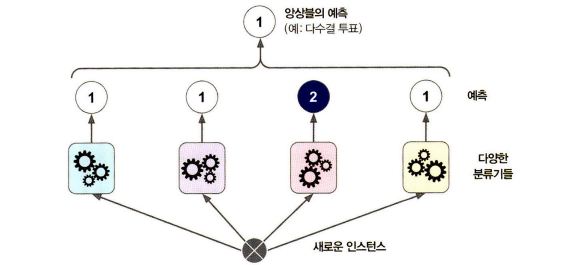

- 각 분류기가 **약한 학습기**일지라도 충분하게 많고 다양하다면 앙상블은 **강한 학습기**가 될 수 있음

- 예측기가 가능한 서로 **독립적이고 오차에 상관관계가 없을 때** 최고의 성능을 발휘 -> 서로다른 알고리즘으로 학습!

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],
    voting='hard'
)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.904
SVC 0.896
VotingClassifier 0.904


직접 투표: voting='hard'

간접 투표: voting='soft'

- 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측
- 모든 분류기가 클래스의 확률을 예측할 수 있어야 함(predict_proba() 있어야 함)


##7.2 배깅과 페이스팅

같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위 구성하여 분류기를 각기 다르게 학습시키면 다양한 분류기를 만들 수 있음

- 배깅: 훈련 세트에서 중복을 허용하여 샘플링 하는 방식
- 페이스팅: 훈련 세트에서 중복을 허용하지 않고 샘플링 하는 방식

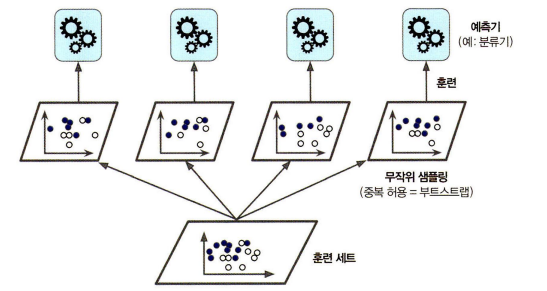

모든 예측기가 훈련을 마치면 앙상블은 예측을 모아서 새로운 샘플에 대한 예측을 생성

- **분류: 통계적 최빈값 계산**
- **회귀: 평균 계산**

수집 함수(분류/회귀)를 통해 편향과 분산을 감소시킴

### 7.2.1 사이킷런의 배깅과 페이스팅

BaggingClassifier(BaggingRegressor) API

- **배깅: bootstrap = True / 페이스팅: bootstrap = False**
- n_jobs: 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정(-1이면 전부)



In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples = 100, bootstrap=True, n_jobs=-1)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

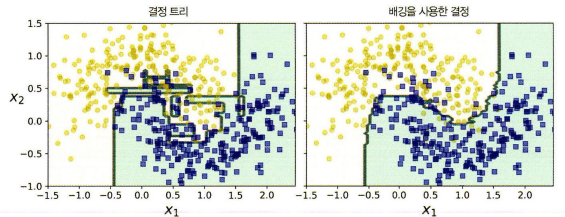

- 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘 됨
- 앙상블은 비슷한 편향에서 더 작은 분산을 만듦

편향: 배깅 >> 페이스팅, but 배깅이 더 나은 모델을 만듦

-> **교차 검증으로 배깅과 페이스팅을 모두 평가**해서 나은 쪽을 선택

### 7.2.2 oob 평가

배깅은 훈련 세트에서 중복을 허용하여 샘플링하기 때문에 여러 번 샘플링 되는 샘플이 있고 **전혀 선택되지 않는 샘플(oob 샘플)**도 있음

**obb 평가: 배깅을 사용할 때 한번도 선택되지 않은 훈련 샘플을 사용하여 평가하는 것**(obb_score=True)

In [10]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    bootstrap = True, n_jobs = -1, oob_score=True)

In [11]:
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_ #평가 점수 결과

0.8986666666666666

In [12]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.896

In [13]:
#oob 샘플에 대한 결정 함수의 값
#각 훈련 샘플의 클래스 확률을 반환

bag_clf.oob_decision_function_ #첫번째 훈련 샘플 양성: 57.5% / 음성: 42.5%

array([[0.4251497 , 0.5748503 ],
       [0.32768362, 0.67231638],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.05882353, 0.94117647],
       [0.33908046, 0.66091954],
       [0.02      , 0.98      ],
       [0.97849462, 0.02150538],
       [0.99393939, 0.00606061],
       [0.78421053, 0.21578947],
       [0.        , 1.        ],
       [0.82513661, 0.17486339],
       [0.8655914 , 0.1344086 ],
       [0.9787234 , 0.0212766 ],
       [0.05769231, 0.94230769],
       [0.        , 1.        ],
       [0.95959596, 0.04040404],
       [0.93258427, 0.06741573],
       [0.98882682, 0.01117318],
       [0.01796407, 0.98203593],
       [0.33163265, 0.66836735],
       [0.91477273, 0.08522727],
       [1.        , 0.        ],
       [0.98181818, 0.01818182],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.60326087, 0.39673913],
       [0.

## 7.3 랜덤 패치와 랜덤 서브스페이스

BaggingClassifier의 **특성 샘플링**
- **랜덤 패치 방식**: 훈련 특성과 샘플을 모두 샘플링하는 것
- **랜덤 서브스페이스 방식**: 훈련 샘플을 모두 사용하고(bootstrap=False, maxfeatures=1.0) 특성(bootstrap=True, maxfeatures<1.0)은 샘플링하는 것

특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춘다.

## 7.4 랜덤 포레스트

max_samples를 훈련 세트의 크기로 지정

In [14]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무**작위로 선택한 특성 후보 중에서 최적의 특성**을 찾는 식으로 **무작위성**을 주입

-> 편향을 손해보는 대신 분산을 낮추어 더욱 훌륭한 모델

In [15]:
#BaggingClassifier로 표현한 RandomForestClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='auto',max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

### 7.4.1 엑스트라 트리

**익스트림 랜덤 트리(엑스트라 트리)** 앙상블: 트리를 더욱 무작위하게 만들기 위해 최적의 임계값을 찾는 대신 후보 특성을 사용해 **극단적으로 무작위하게 분할한 트리**의 랜덤 포레스트

- 편향이 늘어나지만 분산을 낮춤
- 최적의 임곗값을 찾지 않기 때문에 일반적인 랜덤포레스트보다 훨씬 빠름
- ExtraTreesClassifier 이용

### 7.4.2 특성 중요도

특성의 중요도: 사이킷런에서 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인(가중치 평균)
- 랜덤 포레스트로 상대적 중요도를 쉽게 측정할 수 있음

In [16]:
#feature_importances_ 에 중요도 저장(전체 합이 1)
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'],iris['target'])
for name,score in zip(iris['feature_names'],rnd_clf.feature_importances_):
  print(name,score)

sepal length (cm) 0.0920198659714709
sepal width (cm) 0.02478002633209069
petal length (cm) 0.440321258935247
petal width (cm) 0.4428788487611914


## 7.5 부스팅

**부스팅: 약한 학습기 여러개를 연결하여 강한 학습기를 만드는 앙상블 방법**, 앞의 모델을 보완해나가면서 일련의 예측기를 학습

### 7.5.1 에이다 부스트

**에이다 부스트**: 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높여 새로운 예측기를 학습하기 어려운 샘플에 점점 더 맞추는 방식


1.  알고리즘 기반의 첫번째 분류기를 훈련 세트에 훈련시키고 예측
2.  알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높임
3.  두번째 분류기는 업데이트된 가중치를 사용해 훈련하고 다시 예측
4.  다시 가중치를 업데이트
    
    ...

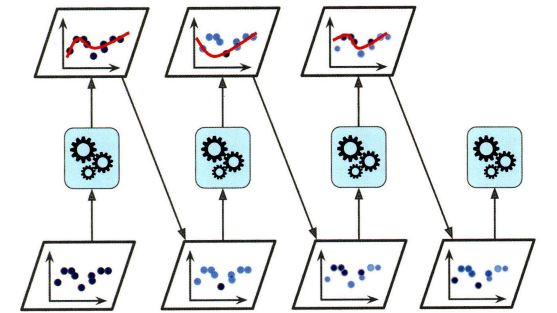



In [17]:
#결정 노드(max_depth=1) 하나와 리프 노드 두개로 이루어진 트리(AdaBoostClassifier의 기본 추정기)
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),n_estimators=200,
    algorithm='SAMME.R',learning_rate=0.5)

ada_clf.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그레이디언트 부스팅

**그레이디언트 부스팅**: 앙상블 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가, 샘플의 가중치를 수정하는 대신 이전 예측기의 residual error에 새로운 예측기를 학습

In [19]:
#그레이디언트 부스티드 회귀 트리(GBRT)
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [21]:
#첫번째 예측기에서 생긴 residual error에 두번째 DecisionTreeRegressor를 훈련
y2 = y-tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

In [22]:
#두번째 예측기가 만든 잔여 오차에 세번째 회귀 모델을 훈련
y3 = y2-tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

In [27]:
#모든 트리의 예측을 더하여 새로운 샘플에 대해 예측
import numpy as np
y_pred = sum(tree.predict(X) for tree in (tree_reg1,tree_reg2,tree_reg3))

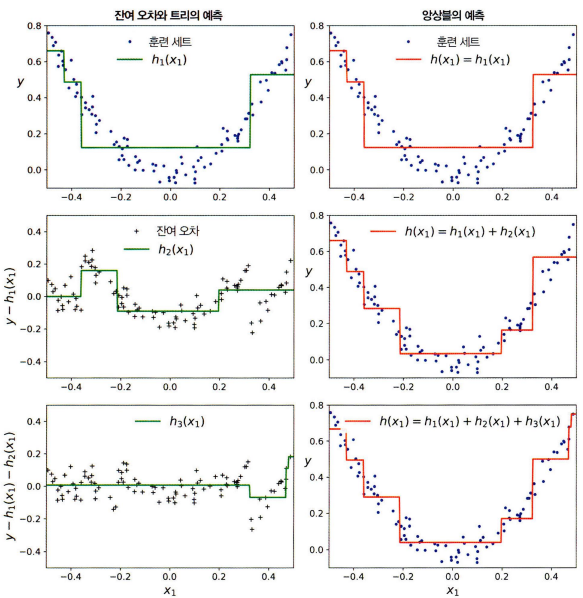

왼쪽 열: 위의 세 트리의 예측 / 오른쪽 열: 앙상블의 예측

-트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아짐

In [29]:
#위의 코드를 GradientBoostingRegressor을 이용해 간단하게 훈련
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

**축소**: 학습률을 낮게 설정해 앙상블을 학습시키기 위해 많은 트리가 필요하지만 예측 성능을 향상시키는 규제 방법

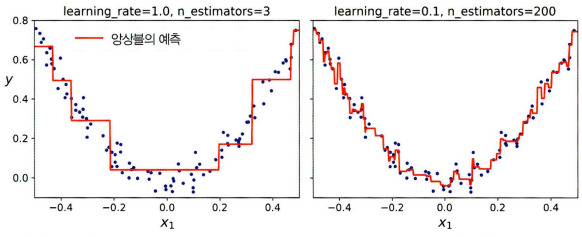


- 작은 학습률로 훈련시킨 두개의 GBRT 앙상블
- 왼쪽: 트리가 충분하지 않음 / 오른쪽: 트리가 너무 많아 과대적합

최적의 트리 수를 찾기 위해 조기 종료 기법을 사용
- **staged_predict()** 메서드 사용
- 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자를 반환

In [30]:
#120개의 트리로 GBRT 앙상블을 훈련시키고 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차를 측정
#마지막에 최적의 트리 수를 사용해 새로운 GBRT 앙상블을 훈련

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train) #최적의 트리 수는 80개!

GradientBoostingRegressor(max_depth=2, n_estimators=80)

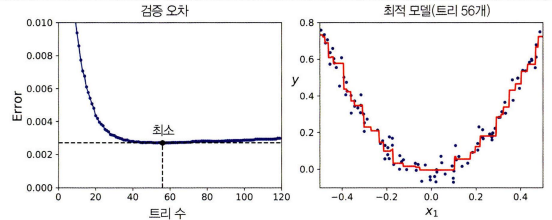

In [31]:
#실제로 훈련을 중지하는 방법으로 조기 종료를 구현
#warm_start = True로 설정해 사이킷런 fit() 메서드가 호출될 때까지 기존 트리를 유지하고 훈련을 추가
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

#연속해서 다섯번의 반복동안 검증 오차가 향상되지 않으면 훈련을 멈춤
min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1,120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break #조기 종료

**확률적 그레이디언트 부스팅**: 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정

- GradientBoostingRegressor의 **subsample** 매개변수 이용
- **XGBoost**: 최적화된 그레이디언트 부스팅 구현 파이썬 라이브러리

In [32]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

[08:11:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [33]:
#자동 조기 종료 기능 제공
xgb_reg.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 2)
y_pred = xgb_reg.predict(X_val)

[08:13:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.468792
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.442291
[2]	validation_0-rmse:0.419754
[3]	validation_0-rmse:0.400845
[4]	validation_0-rmse:0.385645
[5]	validation_0-rmse:0.37213
[6]	validation_0-rmse:0.361654
[7]	validation_0-rmse:0.352629
[8]	validation_0-rmse:0.345654
[9]	validation_0-rmse:0.340459
[10]	validation_0-rmse:0.33038
[11]	validation_0-rmse:0.326835
[12]	validation_0-rmse:0.319015
[13]	validation_0-rmse:0.31447
[14]	validation_0-rmse:0.312732
[15]	validation_0-rmse:0.307784
[16]	validation_0-rmse:0.303751
[17]	validation_0-rmse:0.302734
[18]	validation_0-rmse:0.29821
[19]	validation_0-rmse:0.298281
[20]	validation_0-rmse:0.2949
[21]	validation_0-rmse:0.292879
[22]	validation_0-rmse:0.290112
[23]	validation_0-rmse:0.288467
[24]	validation_0-rmse:0.285835
[25]	validation_0-rmse:0.

## 7.6 스태킹

**스태킹**: (앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신) 모든 모델을 취합하는 모델을 생성하고 훈련

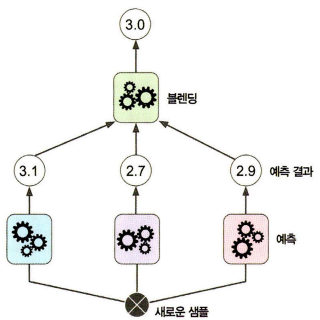

- 각각 다른 값(3.1, 2.7, 2.9)을 예측하고 마지막 예측기(**블렌더 or 메타 학습기**)가 이 예측을 입력으로 맏아 최종 예측을 만듦(3.0)

일반적으로 **홀드 아웃 세트**를 사용해 블렌더를 학습

1.  훈련 세트를 두 개의 서브셋으로 나눔. 첫번째 서브셋은 첫번째 레이어의 예측을 훈련시키기 위해 사용

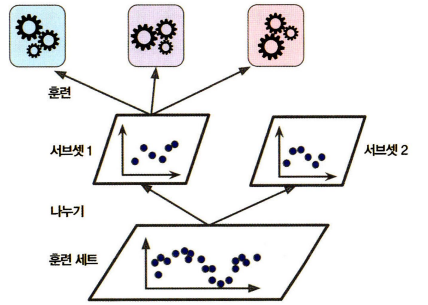



2.  첫번째 레이어의 예측기를 사용해 두번째 홀드 아웃 세트에 대한 예측을 생성. 홀드 아웃 세트의 각 샘플에는 세 개의 예측값이 있음

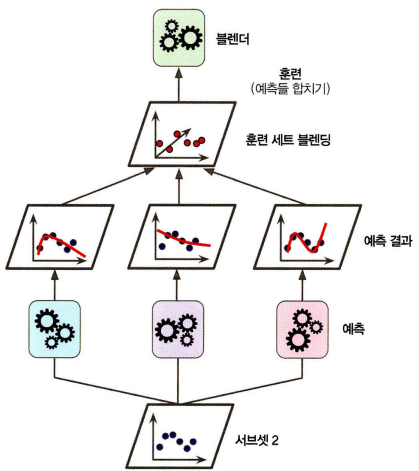
 


이런 방식으로 블렌더를 여러 개 훈련시키는 것도 가능.

훈련 세트를 세 개의 서브셋으로 나누고 -> 첫번째 세트는 첫번째 레이어를 훈련시키는데 사용 -> 두번째 세트는(첫번째 레이어의 예측기로) 두번째 레이어를 훈련시키기 위한 훈련세트를 만드는데 사용 -> 세번째 세트는 (두번째 레이어의 예측기로) 세번째 레이어를 훈련시키기 위한 훈련 세트를 만드는데 사용 -> 새로운 샘플에 대한 예측을 만들 수 있음!

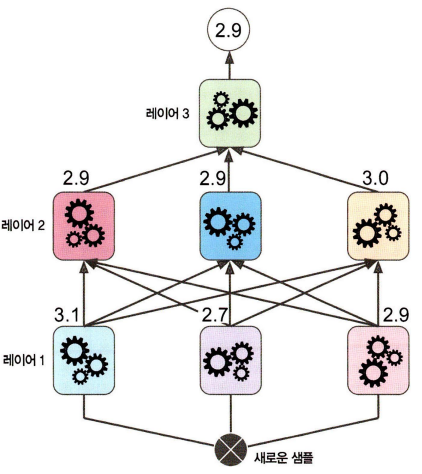